In [6]:
import numpy as np
import pandas as pd
from sklearn.cluster import spectral_clustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
from functions import *

In [2]:
from scipy.stats import kendalltau, pearsonr, spearmanr
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
def sig_pv(x):
    if x <= 0.05:
        return 1
    return 0

# Get expressions of differential expressed proteins

In [5]:
deg_5d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5d5vs6d5_B.csv")
deg_5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5vs6d5_B.csv")
deg_4d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_4d5vs6d5_B.csv")
genes_5d5vs6d5_B = get_deg( deg_5d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )
genes_5vs6d5_B = get_deg( deg_5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )
genes_4d5vs6d5_B = get_deg( deg_4d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )

In [6]:
deGenes = list( set( genes_5d5vs6d5_B['up'] + genes_5vs6d5_B['up'] + genes_4d5vs6d5_B['up'] +\
    genes_5d5vs6d5_B['down'] + genes_5vs6d5_B['down'] + genes_4d5vs6d5_B['down'] ) )
print(len(deGenes))

895


In [7]:
proB = pd.read_excel('../data/Proteomics/Proteomics_B.xlsx')
geneExp = proB[ ['Accession'] + list(proB.columns[-12:])].fillna(0)
geneExp = (geneExp[geneExp.Accession.isin(deGenes)]).reset_index().drop(['index'],axis=1)# select only de genes
geneExp = geneExp.T
geneExp.columns = geneExp.iloc[0]
geneExp = (geneExp.drop(['Accession'], axis=0)).reset_index().drop(['index'],axis=1)

In [8]:
for col in geneExp.columns:
    geneExp[col] = geneExp[col].astype(float)

# Co-expression analysis: Pearson corr & Spectral clustering

In [10]:
# gene_corr = geneExp.corr(method='pearson')
# gene_corr_pv = geneExp.corr(method=pearsonr_pval)
# result = {'corr_matrix':gene_corr,'pv_matrix':gene_corr_pv}
# dump_pickle(result, '../data/Proteomics/corr_result.pkl')

In [9]:
corr_result = load_pickle('../data/Proteomics/corr_result.pkl')
M_corr, M_pv = corr_result['corr_matrix'], corr_result['pv_matrix']
M_sig = M_pv.applymap(sig_pv)
X = M_corr.iloc[:,:].values
gene_list = list( M_corr.columns )
adj_matrix = M_sig.iloc[:,:].values

In [10]:
nclusters = np.arange(10,66,2)
inertias = []
for nc in nclusters:
    kmeans = KMeans(n_clusters=nc, random_state=0, n_init="auto").fit( adj_matrix)
    inertias.append(kmeans.inertia_)

Text(0, 0.5, 'Inertia')

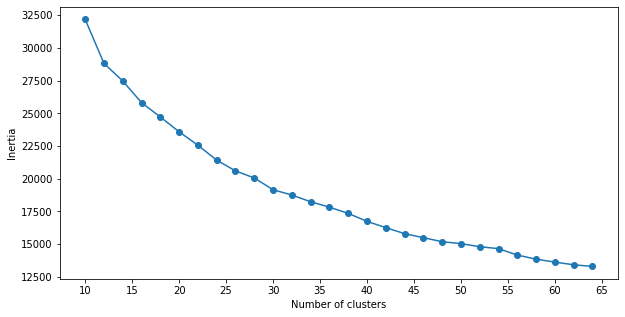

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(nclusters,inertias, marker = 'o');
ax.set_xticks( np.arange(10,66, 5) );
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')

In [22]:
cluster_labels = spectral_clustering(adj_matrix, n_clusters=30,\
                assign_labels='discretize',random_state=0)
module_info = pd.DataFrame(zip(gene_list,cluster_labels), columns=['Protein','Cluster'])

In [27]:
module_info.head()

,Protein,Cluster
0,Q88YM5,3
1,P77886,28
2,Q88VK7,5
3,F9UN60,29
4,Q88U29,2


# Analysis of co-expressed modules

In [41]:
regulons = load_pickle('../data/Proteomics/lpwcfs1_regulons.pkl')

In [29]:
m_sizes = []
for i in range(30):
    m_sizes.append( list(module_info['Cluster']).count(i) )

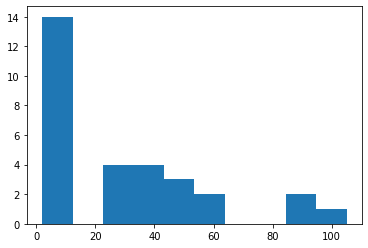

In [37]:
plt.hist(m_sizes);
plt.xlabel('Module size')
plt.ylabel('Count')